# Revision Work

**Notebook Setup**

In [1]:
import sys
sys.path.append("../src")
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [3]:
plt.style.use('ggplot')

In [4]:
df = pd.read_csv("../data/initial_custody_gsprs.csv", low_memory=False)

In [5]:
df["age_gt_45"] = ((df.ic_date // 10000) - (df.date_of_birth // 10000)) > 45
df["age_lt_25"] = ((df.ic_date // 10000) - (df.date_of_birth // 10000)) < 25
df["gender_female"] = df.sex.transform(lambda x: 1 if x == "F" else 0)

In [6]:
df = pd.concat([df, pd.get_dummies(df.race, prefix="race").drop("race_W", axis=1)], axis=1)

In [7]:
df["prior_commits"] = df.ic_prior_commits

df["escape_hist_1"] = df.ic_escpe_hist_1.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_2"] = df.ic_escpe_hist_2.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_3"] = df.ic_escpe_hist_3.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_4"] = df.ic_escpe_hist_4.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_5"] = df.ic_escpe_hist_5.transform(lambda x: 1 if str(x) == "X" else 0)

df["escape_hist_total"] = (
    df["ic_escpe_hist_1"] +
    df["ic_escpe_hist_2"] +
    df["ic_escpe_hist_3"] +
    df["ic_escpe_hist_4"] +
    df["ic_escpe_hist_5"]
)

In [8]:
df = pd.concat(
    [
        df,
        pd.get_dummies(
            df.ic_mrtl_stat_fr_cl,
            prefix="mrt_stat"
        ).drop(["mrt_stat_SIN", "mrt_stat_UNK"], axis=1)
    ],
    axis=1
)

In [9]:
df["employed"] = df.ic_employ_ind.fillna(0).replace("X", 1)

In [10]:
df = df[df.ic_custdy_level > 1]

## Logistic Regression from Paper

In [11]:
df["custody_level"] = df.ic_custdy_level.transform(lambda x: 0 if x <= 3 else 1)
data = df[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed"
    ]
]

data = data.dropna()

In [12]:

X = data.drop("custody_level", axis=1)
Y = data["custody_level"]

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2, random_state=1)

In [14]:
model = LogisticRegression(max_iter=10_000)

In [15]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=10000)

In [16]:
coeffs = pd.concat([
    pd.DataFrame(model.intercept_, ["(Intercept)"], columns=["coef"]),
    pd.DataFrame(model.coef_[0], X.columns, columns=['coef']).sort_values(by='coef', ascending=False)
])

In [17]:
coeffs

,coef
(Intercept),-7.032848
escape_hist_5,2.536285
escape_hist_4,1.879133
ic_institut_adj,1.350059
race_A,0.953177
age_lt_25,0.730370
off_1_prs_max,0.274796
off_1_gs_max,0.177978
prior_commits,0.166200
escape_hist_3,0.162808


In [18]:
control = np.exp(model.intercept_[0]) / (1 + np.exp(model.intercept_[0]))

In [19]:
(np.exp(coeffs) / (1 - control + (control * np.exp(coeffs)))).iloc[1:]

,coef
escape_hist_5,12.504417
escape_hist_4,6.515952
ic_institut_adj,3.847959
race_A,2.590298
age_lt_25,2.073881
off_1_prs_max,1.315895
off_1_gs_max,1.194594
prior_commits,1.180621
escape_hist_3,1.176627
race_B,1.069458


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.920


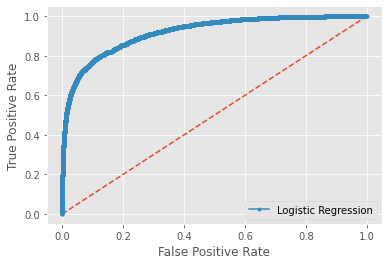

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


ns_probs = [0 for _ in range(len(Y_test))]

lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Setting 2 - 4 Being Low and 5 as High 

In [21]:
df["custody_level"] = df.ic_custdy_level.transform(lambda x: 0 if x <= 4 else 1)
data = df[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed"
    ]
]

data = data.dropna()

In [22]:
X = data.drop("custody_level", axis=1)
Y = data["custody_level"]

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2, random_state=1)

In [24]:
model = LogisticRegression(max_iter=10_000)

In [25]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=10000)

In [26]:
coeffs = pd.concat([
    pd.DataFrame(model.intercept_, ["(Intercept)"], columns=["coef"]),
    pd.DataFrame(model.coef_[0], X.columns, columns=['coef']).sort_values(by='coef', ascending=False)
])

In [27]:
coeffs

,coef
(Intercept),-8.788663
ic_institut_adj,0.645777
age_lt_25,0.540728
escape_hist_5,0.510984
escape_hist_4,0.479882
race_H,0.416962
prior_commits,0.136568
mrt_stat_MAR,0.135278
off_1_gs_max,0.081915
escape_hist_2,0.067926


In [28]:
control = np.exp(model.intercept_[0]) / (1 + np.exp(model.intercept_[0]))

In [29]:
(np.exp(coeffs) / (1 - control + (control * np.exp(coeffs)))).iloc[1:]

,coef
ic_institut_adj,1.907205
age_lt_25,1.717068
escape_hist_5,1.666761
escape_hist_4,1.615732
race_H,1.517226
prior_commits,1.146307
mrt_stat_MAR,1.144830
off_1_gs_max,1.085349
escape_hist_2,1.070275
off_1_prs_max,1.018154


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.714


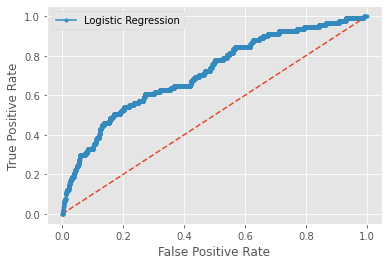

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


ns_probs = [0 for _ in range(len(Y_test))]

lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Multinomial

In [32]:
df["custody_level"] = df.ic_custdy_level
data = df[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed"
    ]
]

data = data.dropna()
X = data.drop("custody_level", axis=1)
Y = data["custody_level"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2, random_state=1)
model = LogisticRegression(multi_class="multinomial", max_iter=10_000)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial')

In [34]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_test, Y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.753 (0.009)
